In [2]:
import pickle
import torch
import sys
sys.path.append('../../data_processing')
sys.path.append('../../model')
sys.path.append('../../../data')
import CNN
import TF_data_loader_gcPBM
import TF_data_loader_gcPBM_seq_only
import TF_data_loader_gcPBM_bubble
import TF_data_loader_gcPBM_bubble_breathing
from torch.utils import data as D
import numpy as np
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn.parallel import DataParallel
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FixedLocator

import glob

In [3]:
def generate_structure(features, pool, kernel, filters, layers):
    structure = {}
    for feature in features:
        structure[feature] = {}
        for poolnum in pool:
            structure[feature][poolnum] = {}
            for kernum in kernel:
                structure[feature][poolnum][kernum] = {}
                for filter in filters:
                    structure[feature][poolnum][kernum][filter] = {}
                    for layer in layers:
                        structure[feature][poolnum][kernum][filter][layer] = []
    return structure

In [4]:
def weight_maker(TF):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_paths = glob.glob('../../../trained_model/gcPBM/**/**/**/**/**/*', recursive=False)
    model_paths = [m for m in model_paths if m.split('/')[-1] == TF]

    features = []
    pool = []
    kernel = []
    filters = []
    layers = []

    for model_path in model_paths:
        # parse the model path to get the TF, layers, filters, kernel, and pool
        feature = model_path.split('/')[-6]
        if feature not in features:
            features.append(str(feature))
        layer = model_path.split('/')[-5]
        if layer not in layers:
            layers.append(str(layer))
        filt = model_path.split('/')[-4]
        if filt not in filters:
            filters.append(str(filt))
        kern = model_path.split('/')[-3]
        if kern not in kernel:
            kernel.append(str(kern))
        p = model_path.split('/')[-2]
        if p not in pool:
            pool.append(str(p))

    weights = generate_structure(features, pool, kernel, filters, layers)

    for model_path in tqdm(model_paths, desc='Model', unit='model', leave=True):
    # parse the model path to get the TF, layers, filters, kernel, and pool
        features = model_path.split('/')[-6]
        layers = model_path.split('/')[-5]
        filters = model_path.split('/')[-4]
        kernel = model_path.split('/')[-3]
        pool = model_path.split('/')[-2]

        check_point = torch.load(model_path, map_location=device)

        if features == 'seq_only':
            model = CNN.CNN(kernel=int(kernel), pool=int(pool), filters=int(filters), layers=int(layers), input_channels=4)
            model.load_state_dict(check_point['state_dict'])
            model = model.to(device)

            weight = model.conv_net[0].weight.data.cpu().numpy().squeeze()

            # Append the true and predicted labels to the respective lists
            weights[features][pool][kernel][filters][layers] = weight

        elif features == 'seq_plus_breathing_features':
            model = CNN.CNN(kernel=int(kernel), pool=int(pool), filters=int(filters), layers=int(layers), input_channels=7)
            model.load_state_dict(check_point['state_dict'])
            model = model.to(device)

            weight = model.conv_net[0].weight.data.cpu().numpy().squeeze()

            # Append the true and predicted labels to the respective lists
            weights[features][pool][kernel][filters][layers] = weight

        elif features == 'bubble_only':
            model = CNN.CNN(kernel=int(kernel), pool=int(pool), filters=int(filters), layers=int(layers), input_channels=134)
            model.load_state_dict(check_point['state_dict'])
            model = model.to(device)

            weight = model.conv_net[0].weight.data.cpu().numpy().squeeze()

            # Append the true and predicted labels to the respective lists
            weights[features][pool][kernel][filters][layers] = weight

        elif features == 'bubble_breathing':
            model = CNN.CNN(kernel=int(kernel), pool=int(pool), filters=int(filters), layers=int(layers), input_channels=137)
            model.load_state_dict(check_point['state_dict'])
            model = model.to(device)

            weight = model.conv_net[0].weight.data.cpu().numpy().squeeze()

            # Append the true and predicted labels to the respective lists
            weights[features][pool][kernel][filters][layers] = weight
    
    return weights

In [30]:
def motif_maker(weight_table):
    for features, feature_dict in weight_table.items():
        for pool, pool_dict in feature_dict.items():
            for kernel, kernel_dict in pool_dict.items():
                for filters, filters_dict in kernel_dict.items():
                    for layers, weights in filters_dict.items():
                        # Determine the row headers based on the features
                        if features == 'seq_only':
                            row_headers = ["A", "G", "C", "T"]
                        elif features == 'seq_plus_breathing_features':
                            row_headers = ["A", "G", "C", "T", "coord", "coord_sq", "flip"]
                        elif features == 'bubble_only':
                            row_headers = ["A", "G", "C", "T"]
                            row_headers.extend(["coord_{}".format(i) for i in range(1, 131)])
                        elif features == 'bubble_breathing':
                            row_headers = ["A", "G", "C", "T", "coord", "coord_sq", "flip"]
                            row_headers.extend(["bubble_coord_{}".format(i) for i in range(1, 131)])

                        if features == 'seq_only':
                            # Create a figure and set its size
                            fig, axs = plt.subplots(figsize=(weights.shape[2], weights.shape[1]))

                            # Plot the heatmap
                            sns.heatmap(
                                weights[0],
                                cmap="coolwarm",
                                annot=True,
                                fmt=".3f",
                                annot_kws={"size": 6},
                                cbar=False,
                                yticklabels=row_headers,
                                ax=axs,
                            )

                            # Set titles and axis labels
                            axs.set_title(f"{features}, pool = {pool}, kernel = {kernel}, filters = {filters}, layers = {layers}")
                            axs.set_xticks(range(weights.shape[2]))
                            axs.set_yticks(np.arange(0.5, weights.shape[1] + 0.5))
                            axs.set_yticklabels(row_headers, fontsize=7)
                            axs.set_xticklabels(range(1, weights.shape[2] + 1), fontsize=7)

                            plt.show()

                        elif features == 'seq_plus_breathing_features':
                            # Create a figure and set its size
                            fig, axs = plt.subplots(nrows=2, gridspec_kw={"height_ratios": [0.6, 0.4]})

                            # Plot the heatmap
                            sns.heatmap(
                                weights[0, :4, :],
                                cmap="coolwarm",
                                annot=True,
                                fmt=".3f",
                                annot_kws={"size": 6},
                                cbar=False,
                                yticklabels=row_headers[:4],
                                ax=axs[0],
                            )

                            sns.heatmap(
                                weights[0, 4:, :],
                                cmap="coolwarm",
                                annot=True,
                                fmt=".3f",
                                annot_kws={"size": 6},
                                cbar=False,
                                yticklabels=row_headers[4:],
                                ax=axs[1],
                            )

                            # Set titles and axis labels
                            axs[0].set_title(f"{features}, pool = {pool}, kernel = {kernel}, filters = {filters}, layers = {layers}")
                            axs[0].set_xticks(range(weights.shape[2]))
                            axs[0].set_yticks(np.arange(0.5, 4.5))
                            axs[0].set_yticklabels(row_headers[:4], fontsize=7)
                            axs[0].set_xticklabels(range(1, weights.shape[2] + 1), fontsize=7)

                            axs[1].set_xticks(range(weights.shape[2]))
                            axs[1].set_yticks(np.arange(0.5, 3.5))
                            axs[1].set_yticklabels(row_headers[4:], fontsize=7)
                            axs[1].set_xticklabels(range(1, weights.shape[2] + 1), fontsize=7)

                            plt.show()

                        elif features == 'bubble_only':
                            # Create a figure and set its size
                            fig, axs = plt.subplots(nrows=2, figsize=(weights.shape[2], 4))

                            # Plot the heatmap
                            sns.heatmap(
                                weights[0, :4, :],
                                cmap="coolwarm",
                                annot=True,
                                fmt=".3f",
                                annot_kws={"size": 6},
                                cbar=False,
                                yticklabels=row_headers[:4],
                                ax=axs[0],
                            )

                            sns.heatmap(
                                weights[0, 4:, :],
                                cmap="coolwarm",
                                annot=False,
                                fmt=".3f",
                                annot_kws={"size": 6},
                                cbar=False,
                                yticklabels=([]),
                                ax=axs[1],
                            )

                            # Set titles and axis labels
                            axs[0].set_title(f"{features}, pool = {pool}, kernel = {kernel}, filters = {filters}, layers = {layers}")
                            axs[0].set_xticks(range(weights.shape[2]))
                            axs[0].set_yticks(np.arange(0.5, 4.5))
                            axs[0].set_yticklabels(row_headers[:4], fontsize=7)
                            axs[0].set_xticklabels(range(1, weights.shape[2] + 1), fontsize=7)

                            axs[1].set_xticks(range(weights.shape[2]))
                            axs[1].set_yticks(np.arange(0.5, 130.5))
                            axs[1].set_yticklabels([])
                            axs[1].set_xticklabels(range(1, weights.shape[2] + 1), fontsize=7)

                            plt.show()

                        elif features == 'bubble_breathing':
                            # Create a figure and set its size
                            fig, axs = plt.subplots(nrows=3, gridspec_kw={"height_ratios": [0.6, 0.4, 0.6]})

                            # Plot the heatmap
                            sns.heatmap(
                                weights[0, :4, :],
                                cmap="coolwarm",
                                annot=True,
                                fmt=".3f",
                                annot_kws={"size": 6},
                                cbar=False,
                                yticklabels=row_headers[:4],
                                ax=axs[0],
                            )

                            sns.heatmap(
                                weights[0, 4:7, :],
                                cmap="coolwarm",
                                annot=True,
                                fmt=".3f",
                                annot_kws={"size": 6},
                                cbar=False,
                                yticklabels=row_headers[4:7],
                                ax=axs[1],
                            )

                            sns.heatmap(
                                weights[0, 7:, :],
                                cmap="coolwarm",
                                annot=False,
                                fmt=".3f",
                                annot_kws={"size": 6},
                                cbar=False,
                                yticklabels=([]),
                                ax=axs[2],
                            )

                            # Set titles and axis labels
                            axs[0].set_title(f"{features}, pool = {pool}, kernel = {kernel}, filters = {filters}, layers = {layers}")
                            axs[0].set_xticks(range(weights.shape[2]))
                            axs[0].set_yticks(np.arange(0.5, 4.5))
                            axs[0].set_yticklabels(row_headers[:4], fontsize=7)
                            axs[0].set_xticklabels(range(1, weights.shape[2] + 1), fontsize=7)

                            axs[1].set_xticks(range(weights.shape[2]))
                            axs[1].set_yticks(np.arange(0.5, 3.5))
                            axs[1].set_yticklabels(row_headers[4:7], fontsize=7)
                            axs[1].set_xticklabels(range(1, weights.shape[2] + 1), fontsize=7)

                            axs[2].set_xticks(range(weights.shape[2]))
                            axs[2].set_yticks(np.arange(0.5, 130.5))
                            axs[2].set_yticklabels([])
                            axs[2].set_xticklabels(range(1, weights.shape[2] + 1), fontsize=7)

                            plt.show()

In [6]:
weight_table = {}

# Iterate over the TF list
for TF in ['mad', 'max', 'myc']:
    # Call the create_true_pred function and assign the results to dynamically generated variable names
    weights = weight_maker(TF)
    
    # Store the true and predicted values in the dictionary
    weight_table[f'{TF}'] = weights


Model:   0%|          | 0/4 [00:00<?, ?model/s]

Model:   0%|          | 0/4 [00:00<?, ?model/s]

Model:   0%|          | 0/4 [00:00<?, ?model/s]

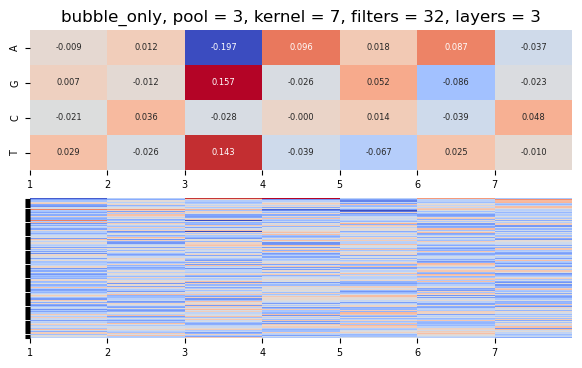

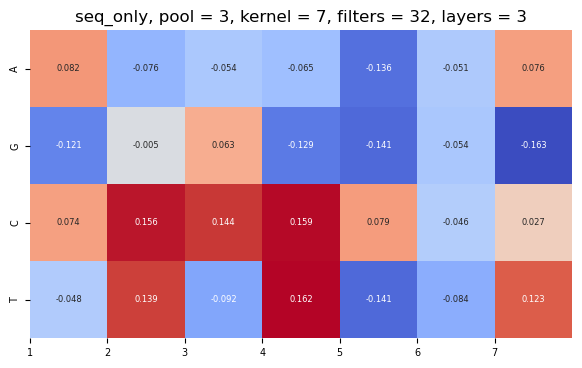

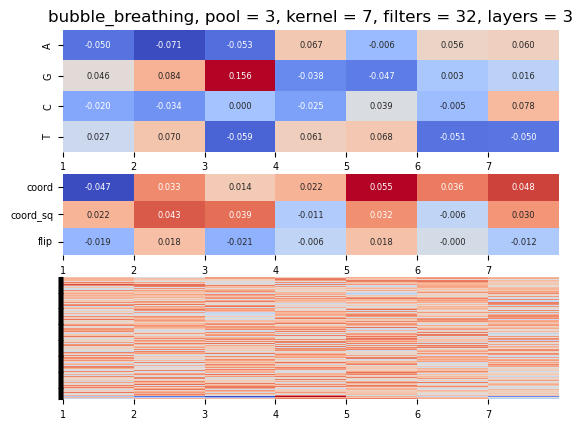

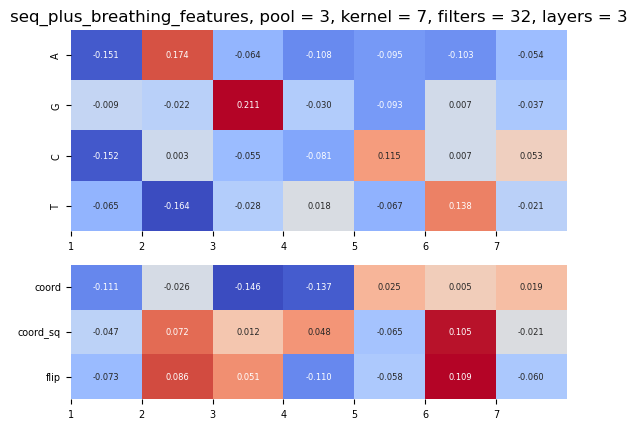

In [31]:
motif_maker(weight_table['mad'])